In [1]:
!pip install windpowerlib
from windpowerlib import WindTurbine, ModelChain
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Liberation Serif']
plt.rcParams['font.sans-serif'] = ['Liberation Sans']
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 1.9 MB/s eta 0:00:00


In [2]:
class PowerCurveInformation:
    def __init__(self, turbine_name, hub_height):
        self.turbine_name = turbine_name.split('/')[0]
        turbine_characteristics = {
            "turbine_type": turbine_name,
            "hub_height": hub_height
        }
        turbine = WindTurbine(**turbine_characteristics)
        self.turbine = turbine
        mc_turbine = ModelChain(turbine)
        wind_speed = np.arange(0, 100, 0.1)
        power = mc_turbine.calculate_power_output(wind_speed, 1)
        first_nonzero_index = np.argmax(power > 0)
        self.cut_in = wind_speed[first_nonzero_index]
        first_zero_after_nonzero = np.argmax(power[first_nonzero_index:] == 0) + first_nonzero_index
        self.cut_off = wind_speed[first_zero_after_nonzero]
        saturation_index = np.argmax(power == max(power))
        self.rated = wind_speed[saturation_index]

In [3]:
power_curve_information = PowerCurveInformation('V126/3450', 126)
WIND_SPEED_LABEL = 'wind speed (m/s)'
WIND_POWER_LABEL = 'wind power (MW)'
FIG_WIDTH = 12
FIG_HEIGHT = 6
LABEL_SIZE = 16

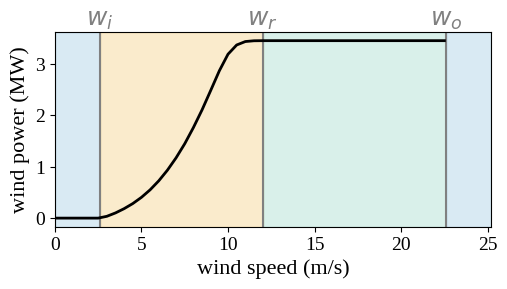

In [4]:
turbine = power_curve_information.turbine
if turbine.power_curve is not None:
    wind_speed = turbine.power_curve['wind_speed'].to_numpy()
    power_mw = turbine.power_curve['value'].to_numpy() / 1e6  # Convert power values from W to MW

    fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_HEIGHT))

    cut_in = power_curve_information.cut_in
    ax.axvspan(0, cut_in, color='#0072B2', alpha=0.15)
    ax.axvline(x=cut_in, color='grey', linewidth=1.5)
    ax.text(cut_in, max(power_mw) * 1.05, '$w_i$', color='grey', ha='center', va='bottom', fontsize=LABEL_SIZE+2)

    rated = power_curve_information.rated
    ax.axvspan(cut_in, rated, color='#E69F00', alpha=0.2)
    ax.axvline(x=rated, color='grey', linewidth=1.5)
    ax.text(rated, max(power_mw) * 1.05, '$w_r$', color='grey', ha='center', va='bottom', fontsize=LABEL_SIZE+2)

    cut_off = power_curve_information.cut_off
    ax.axvspan(rated, cut_off, color='#009E73', alpha=0.15)
    ax.axvline(x=cut_off, color='grey', linewidth=1.5)
    ax.text(cut_off, max(power_mw) * 1.05, '$w_o$', color='grey', ha='center', va='bottom', fontsize=LABEL_SIZE+2)

    ax.axvspan(cut_off, cut_off+cut_in, color='#0072B2', alpha=0.15)

    ax.set_xlabel(WIND_SPEED_LABEL, fontsize=LABEL_SIZE)
    ax.set_ylabel(WIND_POWER_LABEL, fontsize=LABEL_SIZE)
    ax.set_xlim(0, cut_off+cut_in)
    ax.tick_params(axis='both', which='major', labelsize=LABEL_SIZE - 2)
    ax.tick_params(axis='both', which='minor', labelsize=LABEL_SIZE - 4)

    ax.plot(wind_speed, power_mw, '-', color='black', linewidth=2)
    fig.tight_layout()
    name = f'power_curve_{power_curve_information.turbine_name}'
    fig.set_size_inches(FIG_WIDTH / 2.54, FIG_HEIGHT / 2.54)
    fig.savefig(f'{name}.pdf', bbox_inches="tight")